### All packages needed for original implementation

In [1]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda
from torch.utils.data import DataLoader
from torch.optim import Adam
import random

## Full Dataset

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
    
print(device)

cuda


### Pinned Memory

In [3]:
orig_tf = Compose([ToTensor(), Normalize((0.1307,), (0.3081,)),
                   Lambda(torch.flatten)])

orig_train_kwargs = {'batch_size': 50000}
orig_test_kwargs = {'batch_size': 10000}
if device == 'cuda':
    orig_cuda_kwargs = {'num_workers': 1, 'shuffle': True, 'pin_memory': True}
    orig_train_kwargs.update(orig_cuda_kwargs)
    orig_test_kwargs.update(orig_cuda_kwargs)

orig_train_loader = DataLoader(
    MNIST('./data/', train=True, download=True, transform=orig_tf), **orig_train_kwargs
)

orig_test_loader = DataLoader( # may be unnecessary
    MNIST('./data/', train=False, download=True, transform=orig_tf), **orig_test_kwargs
)

### Unpinned Memory

#### 1 sub-process

In [92]:
orig_tf = Compose([ToTensor(), Normalize((0.1307,), (0.3081,)),
                   Lambda(torch.flatten)])

orig_train_kwargs = {'batch_size': 50000}
orig_test_kwargs = {'batch_size': 10000}
if device == 'cuda':
    orig_cuda_kwargs = {'num_workers': 1, 'shuffle': True, 'pin_memory': False}
    orig_train_kwargs.update(orig_cuda_kwargs)
    orig_test_kwargs.update(orig_cuda_kwargs)

orig_train_loader = DataLoader(
    MNIST('./data/', train=True, download=True, transform=orig_tf), **orig_train_kwargs
)

orig_test_loader = DataLoader( # may be unnecessary
    MNIST('./data/', train=False, download=True, transform=orig_tf), **orig_test_kwargs
)

## Reconstructing Original Implementation

In [93]:
def label(x, y, n_labels=10):
    out = x.clone()
    out[:, :n_labels] *= 0.0
    out[range(x.shape[0]), y] = x.max()
    return out

In [94]:
class OrigLayer(nn.Linear):
    def __init__(self, f_in, f_out, bias=True, device=None, dtype=None,
                threshold=2., num_epochs=60):
        super().__init__(f_in, f_out, bias, device, dtype)
        self.relu = nn.ReLU()
        self.opt = Adam(self.parameters(), lr=0.03)
        self.threshold = threshold
        self.num_epochs = num_epochs
    
    def forward(self, x):
        x_direction = x / (x.norm(2, 1, keepdim=True) + 1e-4) # not sure what the point of this is, but it looks kind of like LVQ
        # norm yields L2 norm of abs(x): sum(abs(x)**2)**(1/2); 2 can be replaced by any number using 1st arg
        # using 'fro' as first arg gives L2 norm of x
        # using 'nuc' gives nuclear norm of x: sum(root2(e_i)) for eigenvalues E of X' @ X or X @ X'
        
        return self.relu(torch.mm(x_direction, self.weight.T) + self.bias.unsqueeze(0)) # X_dir @ W' + b
    
    def train(self, x_pos, x_neg):
        for i in range(self.num_epochs):
            # for each image, obtain average of squared activations
            g_pos = self.forward(x_pos).pow(2).mean(1)
            g_neg = self.forward(x_neg).pow(2).mean(1)
            
            # for each image, loss = ln(1 + e^(wrongness))
            # for negative wrongness = positive/negative(goodness - threshold)
            loss = torch.log1p(torch.exp(
                torch.cat([self.threshold - g_pos, g_neg - self.threshold])
            )).mean()
            
            self.opt.zero_grad() # reset gradient to 0
            loss.backward() # calculate gradient - not backpropagation because nothing to propagate to
            self.opt.step() # adjust weights according to Adam optimizer: gradient descent with global, local momentum
            if i % log_interval == 0:
                print('Loss: ', loss.item())
                
        self.opt.zero_grad() # to save memory        
        return self.forward(x_pos).detach(), self.forward(x_neg).detach() # send to next layer

In [95]:
class OrigNet(torch.nn.Module):
    def __init__(self, dims, num_epochs=60, pos_labels=10):
        super().__init__()
        self.layers = []
        for d in range(len(dims) - 1):
            self.layers = self.layers + [OrigLayer(dims[d], dims[d+1], num_epochs=num_epochs).to(device)]
        
        if type(pos_labels) == int:
            self.labels = range(pos_labels)
            self.n_label = pos_labels
        else:
            raise TypeError('parameter pos_labels must be of type Int')
    
    def predict(self, x):
        goodness_per_label = []
        for l in self.labels:
            h = label(x, l, self.n_label)
            goodness = []
            
            for layer in self.layers:
                h = layer(h)
                goodness = goodness + [h.pow(2).mean(1)]
            goodness_per_label += [sum(goodness).unsqueeze(1)]
        
        goodness_per_label = torch.cat(goodness_per_label, 1)
        return goodness_per_label.argmax(1)
    
    def train(self, x_pos, x_neg):
        h_pos, h_neg = x_pos, x_neg
        for i, layer in enumerate(self.layers):
            print('training layer: ', i)
            h_pos, h_neg = layer.train(h_pos, h_neg)

In [96]:
def get_neg(x, y, n_labels=10, ratio=1): # constructed myself
    labels = []
    for n in range(n_labels):
        labels.append(n)
        
    y_neg = []
    for n in range(ratio):
        y_neg.append(torch.zeros_like(y))
    
    for i in range(len(y)):
        labels_ = labels.copy()
        labels_.remove(y[i])
        negs = random.sample(labels_, k=ratio)
        for n in range(len(negs)):
            y_neg[n][i] = negs[n]
            
    x_neg = []
    for yn in y_neg:
        x_neg.append(label(x, yn, n_labels))
    x_neg = torch.cat(x_neg)
    return x_neg

In [97]:
log_interval = 10

In [98]:
a, b = orig_train_loader
x, y = a
x, y = x.to(device), y.to(device)

x_val, y_val = b
x_val = x_val.to(device)
y_val = y_val.to(device)

In [99]:
x_pos = label(x, y)
x_neg = get_neg(x, y)

In [9]:
def run_builtin_training(net, x_pos, x_neg, y_train, x_val, y_val):
    net.train(x_pos, x_neg)
    print('train error:', 1 - net.predict(x).eq(y_train).float().mean().item())
    print('valid error:', 1 - net.predict(x_val).eq(y_val).float().mean().item())

### Simplified version

2 hidden layers, 500 ReLUs each, as in GitHub implementation. Trained for 60 epochs as in paper, and for 1000 epochs as in GitHub implementation

In [129]:
orig_short = OrigNet([784, 500, 500])
orig_full = OrigNet([784, 500, 500], num_epochs=1000)

In [130]:
run_builtin_training(orig_short, x_pos, x_neg, y, x_val, y_val)

training layer:  0
Loss:  1.1267759799957275
Loss:  0.7555526494979858
Loss:  0.7025285959243774
Loss:  0.7051083445549011
Loss:  0.6946920156478882
Loss:  0.6919478178024292
training layer:  1
Loss:  1.126697301864624
Loss:  0.7611115574836731
Loss:  0.7094106078147888
Loss:  0.6954320669174194
Loss:  0.6950199604034424
Loss:  0.6949039697647095
train error: 0.8863399997353554
valid error: 0.8941000029444695


In [131]:
run_builtin_training(orig_full, x_pos, x_neg, y, x_val, y_val)

training layer:  0
Loss:  1.1267536878585815
Loss:  0.7554960250854492
Loss:  0.7023795247077942
Loss:  0.7050467133522034
Loss:  0.6946635842323303
Loss:  0.6918877959251404
Loss:  0.6902346611022949
Loss:  0.6880416870117188
Loss:  0.6850091814994812
Loss:  0.6807626485824585
Loss:  0.6750123500823975
Loss:  0.6676493287086487
Loss:  0.6587328910827637
Loss:  0.6485069990158081
Loss:  0.6374150514602661
Loss:  0.6259715557098389
Loss:  0.6145788431167603
Loss:  0.6034327745437622
Loss:  0.5925993323326111
Loss:  0.5820996761322021
Loss:  0.5719447731971741
Loss:  0.5621438026428223
Loss:  0.5526914596557617
Loss:  0.5435778498649597
Loss:  0.5347889065742493
Loss:  0.526311457157135
Loss:  0.518135666847229
Loss:  0.5102538466453552
Loss:  0.5026540756225586
Loss:  0.4953247010707855
Loss:  0.48825550079345703
Loss:  0.48143601417541504
Loss:  0.4748579263687134
Loss:  0.4685148596763611
Loss:  0.46240001916885376
Loss:  0.4565066397190094
Loss:  0.45082592964172363
Loss:  0.44534698

### Full Version
4 hidden layers, 500 ReLUs each, full connectivity.  
Ran out of memory on my machine, so trying on school computer.

In [11]:
full_net = OrigNet([784, 2000, 2000, 2000, 2000], num_epochs=60)

In [18]:
full_net.train(x_pos, x_neg)

training layer:  0
Loss:  1.126765251159668
Loss:  0.7479006052017212
Loss:  0.7062171101570129
Loss:  0.7044826149940491
Loss:  0.6943631172180176
Loss:  0.6927698254585266
training layer:  1
Loss:  1.126866340637207
Loss:  0.7166959047317505
Loss:  0.7191349267959595
Loss:  0.7072288393974304
Loss:  0.6964314579963684
Loss:  0.6948375105857849
training layer:  2
Loss:  1.1268635988235474
Loss:  0.698647141456604
Loss:  0.6934477686882019
Loss:  0.6957640647888184
Loss:  0.6956759691238403
Loss:  0.6932473182678223
training layer:  3
Loss:  1.1268658638000488
Loss:  0.6932251453399658
Loss:  0.6981924176216125
Loss:  0.6991353034973145
Loss:  0.6945857405662537
Loss:  0.6933739185333252


In [13]:
run_builtin_training(full_net, x_pos, x_neg, y, x_val, y_val)

training layer:  0
Loss:  1.1267642974853516
Loss:  0.7487234473228455
Loss:  0.7057836055755615
Loss:  0.7045142650604248
Loss:  0.6942316293716431
Loss:  0.6925638914108276
training layer:  1
Loss:  1.1268638372421265
Loss:  0.7584021687507629
Loss:  0.7163705229759216
Loss:  0.6950255036354065
Loss:  0.6974285840988159
Loss:  0.6946664452552795
training layer:  2
Loss:  1.126861333847046
Loss:  0.6975537538528442
Loss:  0.6938495635986328
Loss:  0.6964575052261353
Loss:  0.6956017017364502
Loss:  0.6931670904159546
training layer:  3
Loss:  1.1268620491027832
Loss:  0.6931763887405396
Loss:  0.6979731917381287
Loss:  0.6991063952445984
Loss:  0.6949303150177002
Loss:  0.6932732462882996


OutOfMemoryError: CUDA out of memory. Tried to allocate 382.00 MiB (GPU 0; 4.00 GiB total capacity; 10.08 GiB already allocated; 0 bytes free; 10.24 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [12]:
full_net.train(x_pos, x_neg)

training layer:  0
Loss:  1.1267696619033813
Loss:  0.7488387227058411
Loss:  0.7057278156280518
Loss:  0.7045210003852844
Loss:  0.6941994428634644
Loss:  0.6924904584884644
training layer:  1
Loss:  1.126865267753601
Loss:  0.7594606280326843
Loss:  0.7137991786003113
Loss:  0.6947801113128662
Loss:  0.6979151964187622
Loss:  0.6945226192474365
training layer:  2
Loss:  1.1268651485443115
Loss:  0.6990825533866882
Loss:  0.6933636665344238
Loss:  0.6956015229225159
Loss:  0.6956831812858582
Loss:  0.6932703852653503
training layer:  3
Loss:  1.1268653869628906
Loss:  0.6935575604438782
Loss:  0.6974059343338013
Loss:  0.6988356113433838
Loss:  0.6946021914482117
Loss:  0.6933574676513672


In [14]:
temp_net = full_net.to('cpu')

In [17]:
temp_x = x.to('cpu')
temp_y = y.to('cpu')
temp_x_val = x_val.to('cpu')
temp_y_val = y_val.to('cpu')

## Batch Training Modification

Mainly trying to avoid CUDA out-of-memory errors

In [3]:
pin_memory = False
num_workers = 1

In [4]:
orig_tf = Compose([ToTensor(), Normalize((0.1307), (0.3081)), Lambda(torch.flatten)])

train_valid_kwargs = {'batch_size': 256}
test_kwargs = {'batch_size': 10000}
if device == 'cuda':
    cuda_kwargs = {'num_workers': num_workers, 'pin_memory': pin_memory, 'shuffle': False}
    train_valid_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

train_valid_loader = DataLoader(
    MNIST('./data/', train=True, download=True, transform=orig_tf), **train_valid_kwargs
)

orig_test_loader = DataLoader(
    MNIST('./data/', train=False, download=True, transform=orig_tf), **test_kwargs
)

In [5]:
def label(x, y, n_labels=10):
    out = x.clone()
    out[:, :n_labels] *= 0.0
    out[range(x.shape[0]), y] = x.max()
    return out

In [6]:
def get_neg(x, y, n_labels=10, ratio=1): # constructed myself
    labels = []
    for n in range(n_labels):
        labels.append(n)
        
    y_neg = []
    for n in range(ratio):
        y_neg.append(torch.zeros_like(y))
    
    for i in range(len(y)):
        labels_ = labels.copy()
        labels_.remove(y[i])
        negs = random.sample(labels_, k=ratio)
        for n in range(len(negs)):
            y_neg[n][i] = negs[n]
            
    x_neg = []
    for yn in y_neg:
        x_neg.append(label(x, yn, n_labels))
    x_neg = torch.cat(x_neg)
    return x_neg

In [8]:
class LayerOld(nn.Linear):
    def __init__(self, f_in, f_out, bias=True, device=None, dtype=None,
                 threshold=2., n_labels=10, prev_layer=None):
        super().__init__(f_in, f_out, bias, device, dtype)
        self.relu = nn.ReLU()
        self.opt = Adam(self.parameters(), lr=0.03)
        self.threshold = threshold
        self.n_labels = n_labels
        
        if prev_layer != None:
            self.prev_layer = prev_layer.to(device)
        else:
            self.prev_layer = prev_layer
    
    def forward(self, x, from_start=True):
        if from_start and self.prev_layer != None: # Allows me to chain a bunch of layers together
            x = self.prev_layer.forward(x)
        
        # normalize x so mag(x) doesn't affect goodness
        x_direction = x / (x.norm(2, 1, keepdim=True) + 1e-4) # L2 norm of abs(x)
        
        return self.relu(torch.mm(x_direction, self.weight.T) + self.bias.unsqueeze(0)) # X_dir @ W' + b
    
    def train(self, x, y, neg_ratio=1, train_params=True):
        x_pos = label(x, y)
        x_neg = get_neg(x, y, self.n_labels, neg_ratio)
        
        g_pos = self.forward(x_pos).pow(2).mean(1) - self.threshold
        g_neg = self.forward(x_neg).pow(2).mean(1) - self.threshold
        
        loss = torch.log1p(torch.exp(
            torch.cat([self.threshold - g_pos, g_neg - self.threshold])
            )).mean()
        
        if train_params:
            self.opt.zero_grad()
            loss.backward()
            self.opt.step() # adjust weights according to Adam optimizer: gradient descent with global, local momentum
        return loss

In [7]:
class Layer(nn.Linear):
    def __init__(self, f_in, f_out, bias=True, device=None, dtype=None,
                 threshold=2., n_labels=10, prev_layer=None):
        super().__init__(f_in, f_out, bias, device, dtype)
        self.relu = nn.ReLU()
        self.opt = Adam(self.parameters(), lr=0.03)
        self.threshold = threshold
        self.n_labels = n_labels
        
        if prev_layer != None:
            self.prev_layer = prev_layer.to(device)
        else:
            self.prev_layer = prev_layer
    
    def forward(self, x, from_start=True):
        if from_start and self.prev_layer != None: # Allows me to chain a bunch of layers together
            x = self.prev_layer.forward(x)
        
        # normalize x so mag(x) doesn't affect goodness
        x_direction = x / (x.norm(2, 1, keepdim=True) + 1e-4) # L2 norm of abs(x)
        
        return self.relu(torch.mm(x_direction, self.weight.T) + self.bias.unsqueeze(0)) # X_dir @ W' + b
    
    def train(self, x, y, neg_ratio=1, train_params=True):
        x_pos = label(x, y)
        x_neg = get_neg(x, y, self.n_labels, neg_ratio)
        
        g_pos = self.forward(x_pos).pow(2).mean(1) - self.threshold
        g_neg = self.forward(x_neg).pow(2).mean(1) - self.threshold
        
        loss = torch.log1p(torch.exp(
            torch.cat([-g_pos, g_neg])
            )).mean()
        
        if train_params:
            self.opt.zero_grad()
            loss.backward()
            self.opt.step() # adjust weights according to Adam optimizer: gradient descent with global, local momentum
        return loss

In [9]:
class LayerNet2():
    def __init__(self, layer_last, device=None, num_epochs=60, n_labels=10, neg_ratio=1, log_int=1):
        self.default_epochs = num_epochs
        self.default_neg_ratio = neg_ratio
        self.default_log_int = log_int
        self.n_labels = n_labels
        
        self.layers = [layer_last]
        while self.layers[-1].prev_layer != None:
            self.layers.append(self.layers[-1].prev_layer)
        self.layers.reverse()

        self.device = device
        for i in range(len(self.layers)):
            self.layers[i] = self.layers[i].to(device)
    
    def epoch(self, dl, valid=False, valid_batches=39, layer=-1, neg_ratio=None):
        if neg_ratio == None:
            neg_ratio = self.default_neg_ratio
        
        loss = 0
        n = 0
        train = True
        for batch in dl:
            if n == len(dl) - valid_batches:
                if valid:
                    print('Train Loss:', float(loss / n))
                    loss = 0
                    train = False
                else:
                    break
            n += 1
            x, y = batch
            x, y = x.to(device), y.to(device)
            loss += self.layers[layer].train(x, y, neg_ratio=neg_ratio, train_params=train)

        if valid:
            print('Valid Loss:', float(loss / valid_batches), '\n')
    
    def train_layer(self, dl, epochs=None, layer=-1, neg_ratio=None,
                    log_int=None, valid_batches=39):
        if epochs == None:
            epochs = self.default_epochs
        if neg_ratio == None:
            neg_ratio = self.default_neg_ratio
        if log_int == None:
            log_int = self.default_log_int
        
        for i in range(epochs):
            if i % log_int == 0 or i == epochs - 1:
                valid = True
                print('Epoch', i)
            else:
                valid = False
            self.epoch(dl, valid, valid_batches, layer, neg_ratio)
    
    def predict(self, x):
        labelwise_goodness = []
        for lb in range(self.n_labels):
            goodness = []
            x_lb = label(x, lb)
            for layer in self.layers:
                x_lb = layer.forward(x_lb, False)
                goodness += [x_lb.pow(2).mean(1)]
            labelwise_goodness += [sum(goodness).unsqueeze(1)]
        labelwise_goodness = torch.cat(labelwise_goodness, 1)
        
        best_label = labelwise_goodness.argmax(1)
        return best_label
    
    def add_layer(self, layer):
        layer = layer.to(self.device)
        
        assert layer.prev_layer == self.layers[-1]
        self.layers.append(layer)

In [40]:
class LayerNet():
    def __init__(self, layer_last, device=None, num_epochs=61, n_labels=10, neg_ratio=1, log_int=1):
        self.default_epochs = num_epochs
        self.default_neg_ratio = neg_ratio
        self.default_log_int = log_int
        self.n_labels = n_labels
        
        self.layers = [layer_last]
        while self.layers[-1].prev_layer != None:
            self.layers.append(self.layers[-1].prev_layer)
        self.layers.reverse()
        if device == None:
            self.device = self.layers[0].device
        else:
            self.device = device
            for i in range(len(self.layers)):
                self.layers[i] = self.layers[i].to(device)
    
    def epoch(self, dl, valid=False, valid_batches=39, layer=-1, neg_ratio=None):
        if neg_ratio == None:
            neg_ratio = self.default_neg_ratio
        
        loss = 0
        n = 0
        train = True
        for batch in dl:
            if n == len(dl) - valid_batches:
                if valid:
                    print('Train Loss:', float(loss / n))
                    loss = 0
                    train = False
                else:
                    break
            n += 1
            x, y = batch
            x, y = x.to(device), y.to(device)
            loss += self.layers[layer].train(x, y, neg_ratio, train)
        
        if valid:
            print('Valid Loss:', float(loss / valid_batches), '\n')
    
    def train_layer(self, dl, epochs=None, layer=-1, neg_ratio=None, log_int=None, valid_batches=39):
        if epochs == None:
            epochs = self.default_epochs
        if neg_ratio == None:
            neg_ratio = self.default_neg_ratio
        if log_int == None:
            log_int = self.default_log_int
        
        for i in range(epochs):
            if i % log_int == 0:
                valid = True
                print('Epoch', i)
            else:
                valid = False
            self.epoch(dl, valid, valid_batches, layer, neg_ratio)
    
    def predict(self, x):
        labelwise_goodness = []
        for l in range(self.n_labels):
            goodness = []
            x_l = label(x, l)
            for layer in self.layers:
                x_l = layer.forward(x_l, False)
                goodness += [x_l.pow(2).mean(1)]
            goodness_per_label += [sum(goodness).unsqueeze(1)]
        goodness_per_label = torch.cat(goodness_per_label, 1)
        
        best_label = goodness_per_label.argmax(1)
        return best_label
    
    def add_layer(self, layer):
        layer = layer.to(self.device)
        
        assert layer.prev_layer == self.layers[-1]
        self.layers.append(layer)

In [10]:
full_layer_1 = Layer(784, 2000)

In [14]:
learner = LayerNet(full_layer_1, device)

In [15]:
learner.train_layer(train_valid_loader, log_int=10)

Epoch 0
Train Loss: 0.5829491019248962
Valid Loss: 0.5015147924423218 

Epoch 10
Train Loss: 0.17749515175819397
Valid Loss: 0.17058315873146057 

Epoch 20
Train Loss: 0.1109650731086731
Valid Loss: 0.11276230961084366 

Epoch 30
Train Loss: 0.07938504964113235
Valid Loss: 0.08541542291641235 

Epoch 40
Train Loss: 0.06158198416233063
Valid Loss: 0.0705452561378479 

Epoch 50
Train Loss: 0.04947328940033913
Valid Loss: 0.06238589435815811 



In [111]:
learner.train_layer(train_valid_loader, log_int=10)

Epoch 0
Train Loss: 0.7367562055587769
Valid Loss: 0.661160945892334 

Epoch 10
Train Loss: 0.18982559442520142
Valid Loss: 0.1820574551820755 

Epoch 20
Train Loss: 0.11608518660068512
Valid Loss: 0.11534401029348373 

Epoch 30
Train Loss: 0.08182833343744278
Valid Loss: 0.08677788823843002 

Epoch 40
Train Loss: 0.06258013844490051
Valid Loss: 0.07340702414512634 

Epoch 50
Train Loss: 0.05017593875527382
Valid Loss: 0.06328091025352478 

Epoch 60
Train Loss: 0.042162325233221054
Valid Loss: 0.05728112906217575 



In [16]:
learner.train_layer(train_valid_loader, log_int=10)

Epoch 0
Train Loss: 0.7362846732139587
Valid Loss: 0.6617559194564819 

Epoch 10
Train Loss: 0.18972772359848022
Valid Loss: 0.180744931101799 

Epoch 20
Train Loss: 0.11734099686145782
Valid Loss: 0.11492932587862015 

Epoch 30
Train Loss: 0.08205156773328781
Valid Loss: 0.08769664168357849 

Epoch 40
Train Loss: 0.06310053914785385
Valid Loss: 0.0717085674405098 

Epoch 50
Train Loss: 0.050495896488428116
Valid Loss: 0.06615296751260757 

Epoch 60
Train Loss: 0.04145429655909538
Valid Loss: 0.058082301169633865 



In [9]:
full_layer_1 = Layer(784, 2000)

In [10]:
full_layer_2 = Layer(2000, 2000, prev_layer=full_layer_1)

In [11]:
full_layer_3 = Layer(2000, 2000, prev_layer=full_layer_2)

In [12]:
full_layer_4 = Layer(2000, 2000, prev_layer=full_layer_3)

In [25]:
learner = LayerNet(full_layer_1, device)

In [26]:
learner.train_layer(train_valid_loader, log_int=10)

Epoch 0
Train Loss: 0.7362818121910095
Valid Loss: 0.659079909324646 

Epoch 10
Train Loss: 0.18933932483196259
Valid Loss: 0.18134427070617676 

Epoch 20
Train Loss: 0.11615649610757828
Valid Loss: 0.11297759413719177 

Epoch 30
Train Loss: 0.08191442489624023
Valid Loss: 0.08707794547080994 

Epoch 40
Train Loss: 0.06281577795743942
Valid Loss: 0.07247650623321533 

Epoch 50
Train Loss: 0.050239045172929764
Valid Loss: 0.06466172635555267 

Epoch 60
Train Loss: 0.041174933314323425
Valid Loss: 0.058641720563173294 



In [31]:
learner.add_layer(full_layer_2)

In [34]:
learner.train_layer(train_valid_loader, log_int=10)

Epoch 0
Train Loss: 0.28253650665283203
Valid Loss: 0.1903226375579834 

Epoch 10
Train Loss: 0.10848939418792725
Valid Loss: 0.11301835626363754 

Epoch 20
Train Loss: 0.09497683495283127
Valid Loss: 0.10305686295032501 

Epoch 30
Train Loss: 0.08763236552476883
Valid Loss: 0.09927765280008316 

Epoch 40
Train Loss: 0.08302408456802368
Valid Loss: 0.09628699719905853 

Epoch 50
Train Loss: 0.07909025996923447
Valid Loss: 0.09407792240381241 

Epoch 60
Train Loss: 0.07703062146902084
Valid Loss: 0.09203022718429565 



In [35]:
learner.add_layer(full_layer_3)

In [36]:
learner.train_layer(train_valid_loader, log_int=10)

Epoch 0
Train Loss: 0.14118161797523499
Valid Loss: 0.11195836216211319 

Epoch 10
Train Loss: 0.08749993145465851
Valid Loss: 0.09924858063459396 

Epoch 20
Train Loss: 0.08384861797094345
Valid Loss: 0.09779269993305206 

Epoch 30
Train Loss: 0.081159807741642
Valid Loss: 0.0947994589805603 

Epoch 40
Train Loss: 0.0792660340666771
Valid Loss: 0.09717375785112381 

Epoch 50
Train Loss: 0.0769122987985611
Valid Loss: 0.09235663712024689 

Epoch 60
Train Loss: 0.07484643161296844
Valid Loss: 0.09153924137353897 



In [37]:
learner.add_layer(full_layer_4)

In [38]:
learner.train_layer(train_valid_loader, log_int=10)

Epoch 0
Train Loss: 0.11338389664888382
Valid Loss: 0.1008511483669281 

Epoch 10
Train Loss: 0.07920875400304794
Valid Loss: 0.09692607074975967 

Epoch 20
Train Loss: 0.07840470224618912
Valid Loss: 0.09510590881109238 

Epoch 30
Train Loss: 0.07674768567085266
Valid Loss: 0.09902723878622055 

Epoch 40
Train Loss: 0.07668337225914001
Valid Loss: 0.09731530398130417 

Epoch 50
Train Loss: 0.07556270062923431
Valid Loss: 0.09562712907791138 

Epoch 60
Train Loss: 0.07438966631889343
Valid Loss: 0.09968055784702301 



In [65]:
train_error = 0
valid_error = 0
i = 0

for batch in train_valid_loader:
    x, y = batch
    x, y = x.to(device), y.to(device)
    error = learner2.predict(x).eq(y).float().sum().item()
    
    if i < len(train_valid_loader) - 39:
        train_error += error
    else:
        valid_error += error
    i += 1
        
x, y = (None, None)

print('Training Error:', 1.0 - (train_error / 50176))
print('Validation Error:', 1.0 - (valid_error / 9824))

Training Error: 0.005161830357142905
Validation Error: 0.022699511400651518


In [69]:
torch.save(learner2.layers[-1].state_dict(), 'orig_first_fully_trained.pth')

In [14]:
full_layer_1 = Layer(784, 2000)
full_layer_2 = Layer(2000, 2000, prev_layer=full_layer_1)
full_layer_3 = Layer(2000, 2000, prev_layer=full_layer_2)
full_layer_4 = Layer(2000, 2000, prev_layer=full_layer_3)

In [10]:
full_layer_4.load_state_dict(torch.load('orig_first_fully_trained.pth', weights_only=True))

C:\Users\sjdim\anaconda3\envs\compatibility\lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


<All keys matched successfully>

In [15]:
learner2 = LayerNet2(full_layer_4, device=device)

In [12]:
train_error = 0
valid_error = 0
i = 0

for batch in train_valid_loader:
    x, y = batch
    x, y = x.to(device), y.to(device)
    error = learner2.predict(x).eq(y).float().sum().item()
    
    if i < len(train_valid_loader) - 39:
        train_error += error
    else:
        valid_error += error
    i += 1
        
x, y = (None, None)

print('Training Error:', 1.0 - (train_error / 50176))
print('Validation Error:', 1.0 - (valid_error / 9824))

Training Error: 0.005161830357142905
Validation Error: 0.022699511400651518


In [12]:
saved_double_threshold_net = Layer(2000, 2000, prev_layer=Layer(
    2000, 2000, prev_layer=Layer(2000, 2000, prev_layer=Layer(784, 2000))))
saved_double_threshold_net.load_state_dict(torch.load('orig_fully_trained_double_threshold.pth'))
learner0 = LayerNet2(saved_double_threshold_net, device=device)

Note: this is the same model as above. It was renamed when I realized that I had been subtracting the threshold from the goodness when assigning `g_pos` and `g_neg`, then doing so again when computing the loss (this version of `Layer` is preserved as `LayerOld`).

In [14]:
all_ys = [[[],[]], [[],[]]]
n = 0

for batch in train_valid_loader:
    if n < len(train_valid_loader) - 39:
        i = 0
    else:
        i = 1
    n += 1
        
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_hat = learner0.predict(x)
    
    all_ys[i][0].append(y)
    all_ys[i][1].append(y_hat)
    
for i in (0,1):
    for j in (0,1):
        if type(all_ys[i][j]) != torch.Tensor:
            all_ys[i][j] = torch.cat(all_ys[i][j])

In [15]:
from fastai.vision.all import show_image

C:\Users\sjdim\anaconda3\envs\compatibility\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


<Axes: >

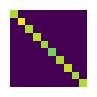

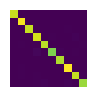

In [35]:
train_ys = torch.stack(all_ys[0], 1)
valid_ys = torch.stack(all_ys[1], 1)

train_matrix = torch.zeros(10, 10).to(device)
valid_matrix = torch.zeros(10, 10).to(device)

for i,j in train_ys:
    train_matrix[i,j] += 1
for i,j in valid_ys:
    valid_matrix[i,j] += 1

show_image(train_matrix)
show_image(valid_matrix)

In [27]:
learner = LayerNet2(Layer(784, 2000), device)
learner.train_layer(train_valid_loader, log_int=10)

Epoch 0
Train Loss: 0.6792289614677429
Valid Loss: 0.5989934206008911 

Epoch 10
Train Loss: 0.22840581834316254
Valid Loss: 0.21617694199085236 

Epoch 20
Train Loss: 0.15570928156375885
Valid Loss: 0.1535790115594864 

Epoch 30
Train Loss: 0.12682606279850006
Valid Loss: 0.128984734416008 

Epoch 40
Train Loss: 0.1104545146226883
Valid Loss: 0.11660335212945938 

Epoch 50
Train Loss: 0.10062313079833984
Valid Loss: 0.11265325546264648 

Epoch 59
Train Loss: 0.0950435996055603
Valid Loss: 0.1060449555516243 



In [28]:
learner.add_layer(Layer(2000, 2000, prev_layer=learner.layers[-1]))
learner.train_layer(train_valid_loader, log_int=10)

Epoch 0
Train Loss: 0.22743889689445496
Valid Loss: 0.16252508759498596 

Epoch 10
Train Loss: 0.11291386187076569
Valid Loss: 0.11725227534770966 

Epoch 20
Train Loss: 0.10263870656490326
Valid Loss: 0.11128387600183487 

Epoch 30
Train Loss: 0.09617090225219727
Valid Loss: 0.10610364377498627 

Epoch 40
Train Loss: 0.09247614443302155
Valid Loss: 0.10631919652223587 

Epoch 50
Train Loss: 0.08947904407978058
Valid Loss: 0.10463357716798782 

Epoch 59
Train Loss: 0.08738861232995987
Valid Loss: 0.10195720195770264 



In [29]:
learner.add_layer(Layer(2000, 2000, prev_layer=learner.layers[-1]))
learner.train_layer(train_valid_loader, log_int=10)

Epoch 0
Train Loss: 0.1519303023815155
Valid Loss: 0.12528231739997864 

Epoch 10
Train Loss: 0.09692980349063873
Valid Loss: 0.10787487030029297 

Epoch 20
Train Loss: 0.09199530631303787
Valid Loss: 0.10616174340248108 

Epoch 30
Train Loss: 0.08969566226005554
Valid Loss: 0.10500223189592361 

Epoch 40
Train Loss: 0.0876132920384407
Valid Loss: 0.10790468007326126 

Epoch 50
Train Loss: 0.08461692184209824
Valid Loss: 0.10253792256116867 

Epoch 59
Train Loss: 0.08430112898349762
Valid Loss: 0.10280666500329971 



In [30]:
learner.add_layer(Layer(2000, 2000, prev_layer=learner.layers[-1]))
learner.train_layer(train_valid_loader, log_int=10)

Epoch 0
Train Loss: 0.1269950121641159
Valid Loss: 0.11377927660942078 

Epoch 10
Train Loss: 0.08995765447616577
Valid Loss: 0.11352824419736862 

Epoch 20
Train Loss: 0.08647839725017548
Valid Loss: 0.10862229764461517 

Epoch 30
Train Loss: 0.0872519463300705
Valid Loss: 0.10757683962583542 

Epoch 40
Train Loss: 0.08581250160932541
Valid Loss: 0.10621087998151779 

Epoch 50
Train Loss: 0.08307977765798569
Valid Loss: 0.10309839248657227 

Epoch 59
Train Loss: 0.08509499579668045
Valid Loss: 0.10942553728818893 



In [31]:
train_error = 0
valid_error = 0
i = 0

for batch in train_valid_loader:
    x, y = batch
    x, y = x.to(device), y.to(device)
    error = learner.predict(x).eq(y).float().sum().item()
    
    if i < len(train_valid_loader) - 39:
        train_error += error
    else:
        valid_error += error
    i += 1
        
x, y = (None, None)

print('Training Error:', 1.0 - (train_error / 50176))
print('Validation Error:', 1.0 - (valid_error / 9824))

Training Error: 0.010263871173469385
Validation Error: 0.026465798045602562


In [32]:
torch.save(learner.layers[-1].state_dict(), 'orig_fully_trained_1.pth')

In [49]:
learner0.layers[-1]

Layer(
  in_features=2000, out_features=2000, bias=True
  (relu): ReLU()
  (prev_layer): Layer(
    in_features=2000, out_features=2000, bias=True
    (relu): ReLU()
    (prev_layer): Layer(
      in_features=2000, out_features=2000, bias=True
      (relu): ReLU()
      (prev_layer): Layer(
        in_features=784, out_features=2000, bias=True
        (relu): ReLU()
      )
    )
  )
)

In [51]:
saved_net = learner0.layers[-1]
saved_net.load_state_dict(torch.load('orig_fully_trained_1.pth', weights_only=True))

learner1 = LayerNet2(saved_net, device)

In [53]:
all_ys = [[[],[]], [[],[]]]
n = 0

for batch in train_valid_loader:
    if n < len(train_valid_loader) - 39:
        i = 0
    else:
        i = 1
    n += 1
        
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_hat = learner1.predict(x)
    
    all_ys[i][0].append(y)
    all_ys[i][1].append(y_hat)
    
for i in (0,1):
    for j in (0,1):
        if type(all_ys[i][j]) != torch.Tensor:
            all_ys[i][j] = torch.cat(all_ys[i][j])

<Axes: >

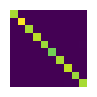

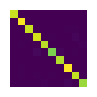

In [54]:
train_ys = torch.stack(all_ys[0], 1)
valid_ys = torch.stack(all_ys[1], 1)

train_matrix = torch.zeros(10, 10).to(device)
valid_matrix = torch.zeros(10, 10).to(device)

for i,j in train_ys:
    train_matrix[i,j] += 1
for i,j in valid_ys:
    valid_matrix[i,j] += 1

show_image(train_matrix)
show_image(valid_matrix)

Object `nn.Linear.clone` not found.


In [ ]:
print('------Layer 1------')
learner = LayerNet2(Layer(784, 2000), device)
learner.train_layer(train_valid_loader, log_int=10)

print('------Layer 2------')
learner.add_layer(Layer(2000, 2000, prev_layer=learner.layers[-1]))
learner.train_layer(train_valid_loader, log_int=10)

print('------Layer 3------')
learner.add_layer(Layer(2000, 2000, prev_layer=learner.layers[-1]))
learner.train_layer(train_valid_loader, log_int=10)

print('------Layer 4------')
learner.add_layer(Layer(2000, 2000, prev_layer=learner.layers[-1]))
learner.train_layer(train_valid_loader, log_int=10)

train_error = 0
valid_error = 0
i = 0

for batch in train_valid_loader:
    x, y = batch
    x, y = x.to(device), y.to(device)
    error = learner.predict(x).eq(y).float().sum().item()
    
    if i < len(train_valid_loader) - 39:
        train_error += error
    else:
        valid_error += error
    i += 1
        
x, y = (None, None)

print('Training Error:', 1.0 - (train_error / 50176))
print('Validation Error:', 1.0 - (valid_error / 9824))

------Layer 1------
Epoch 0
Train Loss: 0.6784642338752747
Valid Loss: 0.5968786478042603 

Epoch 10
Train Loss: 0.2245180904865265
Valid Loss: 0.21209445595741272 

Epoch 20
Train Loss: 0.1549459844827652
Valid Loss: 0.15133269131183624 



In [ ]:
torch.save(learner.layers[-1].state_dict(), 'orig_fully_trained_2.pth')

### LVQ-Modified Training: Experimental, may not work as intended

In [8]:
class LVQlikeLayer(Layer):
    def __init__(self, f_in, f_out, window, bias=True, device=None,
                 dtype=None, n_labels=10, prev_layer=None):
        super().__init__(f_in, f_out, bias, device, dtype, None, n_labels, prev_layer)
        self.window = window
    
    def train(self, x, y, neg_ratio=1, train_params=True, wind_mod=None):
        if wind_mod != None:
            window = self.window * wind_mod
        else:
            window = self.window
        
        g_neg = []
        for n in range(self.n_labels):
            yn = (y != n)
            xn = x * yn.unsqueeze(1)
            xn = label(xn, n) * yn.unsqueeze(1)
            gn = self.forward(xn).pow(2).mean(1) * yn
            g_neg.append(gn)
        g_neg.sort(key=torch.mean, reverse=True)
        g_neg = torch.nan_to_num(g_neg[0])
        
        x_pos = label(x, y)
        x_pos = x_pos[g_neg.nonzero()].squeeze()
        g_pos = self.forward(x_pos).pow(2).mean(1)
        g_neg = g_neg[g_neg.nonzero()].squeeze()
        
        true_loss = torch.log1p(torch.exp(
            torch.cat([-g_pos, g_neg])
            )).mean()
        
        if not train_params:
            return true_loss, len(g_pos)
        
        in_window = (g_pos.div(g_neg) < window)
        in_window *= (g_neg.div(g_pos) < window)
        
        g_pos = torch.nan_to_num(g_pos)
        g_neg = torch.nan_to_num(g_neg)
        g_pos = g_pos[in_window.nonzero()].squeeze()
        g_neg = g_neg[in_window.nonzero()].squeeze()
        assert g_pos.shape == g_neg.shape
        
        if g_pos.dim() == 0:
            g_pos = g_pos.unsqueeze(0)
        if g_neg.dim() == 0:
            g_neg = g_neg.unsqueeze(0)
        
        if g_pos.shape == 0:
            print('No values within window')
            return 0, 0
            
        func_loss = torch.log1p(torch.exp(
            torch.cat([-g_pos, g_neg])
            )).mean()
        
        self.opt.zero_grad()
        func_loss.backward()
        self.opt.step() # adjust weights according to Adam optimizer: gradient descent with global, local momentum
        return func_loss, len(g_pos)

In [9]:
class LayerNet3():
    def __init__(self, layer_last, device=None, num_epochs=60, n_labels=10, neg_ratio=1, log_int=1):
        self.default_epochs = num_epochs
        self.default_neg_ratio = neg_ratio
        self.default_log_int = log_int
        self.n_labels = n_labels
        
        self.layers = [layer_last]
        while self.layers[-1].prev_layer != None:
            self.layers.append(self.layers[-1].prev_layer)
        self.layers.reverse()

        self.device = device
        for i in range(len(self.layers)):
            self.layers[i] = self.layers[i].to(device)
    
    def epoch(self, dl, valid=False, valid_batches=39, layer=-1, neg_ratio=None, wind_mod=0):
        if neg_ratio == None:
            neg_ratio = self.default_neg_ratio
        
        loss = 0
        n = 0
        train = True
        i = 0
        for batch in dl:
            if n == len(dl) - valid_batches:
                if valid:
                    print('Train Loss:', float(loss / n))
                    loss = 0
                    train = False
                else:
                    break
            n += 1
            x, y = batch
            x, y = x.to(device), y.to(device)
            if wind_mod == 0:
                loss += self.layers[layer].train(x, y, neg_ratio=neg_ratio, train_params=train)
            else:
                l, d = self.layers[layer].train(x, y, neg_ratio=neg_ratio,
                                        train_params=train, wind_mod=wind_mod)
                loss += l*d
                i += d
                
        if valid:
            if wind_mod == 0: # for compatibility with older layer types
                print('Valid Loss:', float(loss / valid_batches), '\n')
            else:
                print('Valid Loss:', float(loss / i), '\n')
    
    def train_layer(self, dl, epochs=None, layer=-1, neg_ratio=None,
                    log_int=None, valid_batches=39, window_func=None, w_scale=None):
        if epochs == None:
            epochs = self.default_epochs
        if neg_ratio == None:
            neg_ratio = self.default_neg_ratio
        if log_int == None:
            log_int = self.default_log_int
        
        for i in range(epochs):
            if i % log_int == 0 or i == epochs - 1:
                valid = True
                print('Epoch', i)
            else:
                valid = False
                
            if window_func in ('l', 'linear'):
                wind_mod = w_scale * i
            elif window_func in ('e', 'exp'):
                wind_mod = w_scale ** i
            else:
                wind_mod = None
            self.epoch(dl, valid, valid_batches, layer, neg_ratio, wind_mod)
    
    def predict(self, x):
        labelwise_goodness = []
        for lb in range(self.n_labels):
            goodness = []
            x_lb = label(x, lb)
            for layer in self.layers:
                x_lb = layer.forward(x_lb, False)
                goodness += [x_lb.pow(2).mean(1)]
            labelwise_goodness += [sum(goodness).unsqueeze(1)]
        labelwise_goodness = torch.cat(labelwise_goodness, 1)
        
        best_label = labelwise_goodness.argmax(1)
        return best_label
    
    def add_layer(self, layer):
        layer = layer.to(self.device)
        
        assert layer.prev_layer == self.layers[-1]
        self.layers.append(layer)

In [ ]:
lvq_like_learner = LayerNet3(LVQlikeLayer(784, 2000, 2), device)
lvq_like_learner.train_layer(train_valid_loader, log_int=10)

Epoch 0
Train Loss: 158.6410675048828
Valid Loss: 0.11248166859149933 

Epoch 10
Train Loss: 13.27021598815918
Valid Loss: 0.4556610584259033 

Epoch 20
Train Loss: nan
Valid Loss: 0.5295175313949585 

Epoch 30


In [11]:
len(train_valid_loader) / 2

117.5

In [12]:
lvq_like_learner = LayerNet3(LVQlikeLayer(784, 2000, 2), device)
lvq_like_learner.train_layer(train_valid_loader, log_int=10, valid_batches=118)

Epoch 0
Train Loss: 160.37692260742188
Valid Loss: 0.34702268242836 

Epoch 10
Train Loss: 36.12591552734375
Valid Loss: 0.5403748154640198 

Epoch 20
Train Loss: 9.646214485168457
Valid Loss: 0.6188862919807434 

Epoch 30
Train Loss: 6.732538223266602
Valid Loss: 0.6190103888511658 

Epoch 40
Train Loss: nan
Valid Loss: 0.6175531148910522 

Epoch 50
Train Loss: nan
Valid Loss: 0.6195737719535828 

Epoch 59
Train Loss: nan
Valid Loss: 0.6218056082725525 



In [14]:
train_error = 0
valid_error = 0
i = 0

for batch in train_valid_loader:
    x, y = batch
    x, y = x.to(device), y.to(device)
    error = lvq_like_learner.predict(x).eq(y).float().sum().item()
    
    if i < len(train_valid_loader) - 39:
        train_error += error
    else:
        valid_error += error
    i += 1
        
x, y = (None, None)

print('Training Error:', 1.0 - (train_error / 50176))
print('Validation Error:', 1.0 - (valid_error / 9824))

Training Error: 0.07178730867346939
Validation Error: 0.07196661237785018


In [16]:
all_ys = [[[],[]], [[],[]]]
n = 0

for batch in train_valid_loader:
    if n < len(train_valid_loader) - 39:
        i = 0
    else:
        i = 1
    n += 1
        
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_hat = lvq_like_learner.predict(x)
    
    all_ys[i][0].append(y)
    all_ys[i][1].append(y_hat)
    
for i in (0,1):
    for j in (0,1):
        if type(all_ys[i][j]) != torch.Tensor:
            all_ys[i][j] = torch.cat(all_ys[i][j])

In [21]:
from fastai.vision.all import show_image

C:\Users\sjdim\anaconda3\envs\compatibility\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


<Axes: >

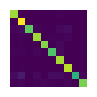

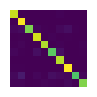

In [17]:
train_ys = torch.stack(all_ys[0], 1)
valid_ys = torch.stack(all_ys[1], 1)

train_matrix = torch.zeros(10, 10).to(device)
valid_matrix = torch.zeros(10, 10).to(device)

for i,j in train_ys:
    train_matrix[i,j] += 1
for i,j in valid_ys:
    valid_matrix[i,j] += 1

show_image(train_matrix)
show_image(valid_matrix)

In [18]:
lvq_like_learner = LayerNet3(LVQlikeLayer(784, 2000, 2), device)
lvq_like_learner.train_layer(train_valid_loader, log_int=10, valid_batches=118)

Epoch 0
Train Loss: 160.5646209716797
Valid Loss: 0.3469107151031494 

Epoch 10
Train Loss: 38.26777267456055
Valid Loss: 0.5361486673355103 

Epoch 20
Train Loss: 10.667709350585938
Valid Loss: 0.6172273755073547 

Epoch 30
Train Loss: 7.372105598449707
Valid Loss: 0.6215351819992065 

Epoch 40
Train Loss: nan
Valid Loss: 0.6201073527336121 

Epoch 50
Train Loss: nan
Valid Loss: 0.6219157576560974 

Epoch 59
Train Loss: nan
Valid Loss: 0.6218854188919067 



In [19]:
train_error = 0
valid_error = 0
i = 0

for batch in train_valid_loader:
    x, y = batch
    x, y = x.to(device), y.to(device)
    error = lvq_like_learner.predict(x).eq(y).float().sum().item()
    
    if i < len(train_valid_loader) - 39:
        train_error += error
    else:
        valid_error += error
    i += 1
        
x, y = (None, None)

print('Training Error:', 1.0 - (train_error / 50176))
print('Validation Error:', 1.0 - (valid_error / 9824))

Training Error: 0.07866310586734693
Validation Error: 0.07379885993485347


In [20]:
all_ys = [[[],[]], [[],[]]]
n = 0

for batch in train_valid_loader:
    if n < len(train_valid_loader) - 39:
        i = 0
    else:
        i = 1
    n += 1
        
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_hat = lvq_like_learner.predict(x)
    
    all_ys[i][0].append(y)
    all_ys[i][1].append(y_hat)
    
for i in (0,1):
    for j in (0,1):
        if type(all_ys[i][j]) != torch.Tensor:
            all_ys[i][j] = torch.cat(all_ys[i][j])

In [21]:
from fastai.vision.all import show_image

<Axes: >

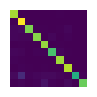

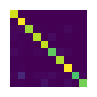

In [22]:
train_ys = torch.stack(all_ys[0], 1)
valid_ys = torch.stack(all_ys[1], 1)

train_matrix = torch.zeros(10, 10).to(device)
valid_matrix = torch.zeros(10, 10).to(device)

for i,j in train_ys:
    train_matrix[i,j] += 1
for i,j in valid_ys:
    valid_matrix[i,j] += 1

show_image(train_matrix)
show_image(valid_matrix)

In [9]:
mini_path = untar_data(URLs.MNIST_SAMPLE)

In [8]:
tf = transforms.Compose([
                    transforms.Lambda(Image.open),
                    transforms.ToTensor(),
                    transforms.Normalize((0.1307,), (0.3081,)),
                    transforms.Lambda(torch.flatten)
])

In [ ]:
mini_train = get_image_files(mini_path, 'train')

In [11]:
get_image_files??

Signature: get_image_files(path, recurse=True, folders=None)
Source:   
def get_image_files(path, recurse=True, folders=None):
    "Get image files in `path` recursively, only in `folders`, if specified."
    return get_files(path, extensions=image_extensions, recurse=recurse, folders=folders)
File:      c:\users\sjdim\anaconda3\envs\compatibility\lib\site-packages\fastai\data\transforms.py
Type:      function